## practicalMixGaussA

October 2017: This lab has been converted to Python by Stratos Skordos. Any errors are my fault.  
October 2018: This lab has been checked by Mohamed Sayed. Any errors are now my fault.

Tested against Python 3.6.6. Required Python modules:
* numpy
* scipy
* matplotlib
* pillow


This lab explores fitting simple parametric models to visual data.
The goal of this part of the lab (part A) is to fit one Gaussian model to the
data for skin and another Gaussian to non-skin pixels, and use this to
find the posterior probability that each pixel in an image is skin.
The aim of part B is to fit a mixture of
Gaussians model to one dimensional data. The aim of part C is to fit a
mixture of Gaussians model to the RGB data.
The aim of Part D is to apply what we've learned to real data.

You should use this template for your code and fill in the missing
sections marked "TO DO".




-----------------------------------
PLEASE NOTE: When implementing equations, you should only be using
"simple" numpy commands, such as np.mean(). When it comes to functions like cov(), you should
implement them yourself to show that you know what the functions are doing. 

You can check your cov() implementation against numpy's, **but
beware, sometimes there are subtle differences
between vanilla equations and what the numpy implememntation uses.**

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio

from numpy import sqrt, pi, exp, transpose, matmul
from numpy.linalg import det, inv

%matplotlib inline


Load in a test image and the corresponding ground truth segmentation mask. Your goal for this part of the lab is to segment this 
image and acheive a segmentation mask that's close to the ground truth mask.

In [2]:
#loading the image
im = plt.imread('bob_small.jpeg');
#loading the segmentation mask
gt = spio.loadmat('bob_GroundTruth_small.mat', squeeze_me=True)['gt']

Text(0.5, 1.0, 'Ground Truth')

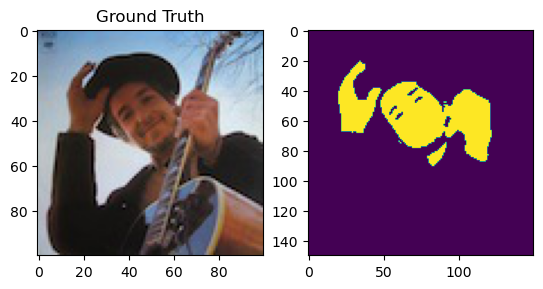

In [3]:
# display the test image and the ground truth mask

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(im)
ax1.set_title('Image')
ax2.imshow(gt)
ax1.set_title('Ground Truth')

### My Explanation


Load in training data. The file contains two variables. Both are sized at 3 x 10000 (3 for RGB dimensions 
and 10000 for the number of data pixels). Each column contains RGB information for one pixel. 

In [4]:
# load the file
trainingData = spio.loadmat('RGBSkinNonSkin.mat', squeeze_me=True)

#extract the non-skin matrix
RGBNonSkin = np.float32(trainingData['RGBNonSkin'])
#extract the skin matrix
RGBSkin = np.float32(trainingData['RGBSkin'])

**TODO HERE**:

This function fits a single Gaussian distribution to your data. Fill in the TODO(s) now before moving on.

In [5]:
#==========================================================================
#==========================================================================

def fitGaussianModel(data):    
    """
    Returns the mean and covariance for a set of multidimensaional data.  
    It is assumed that each column of the 2D array, data, contains a single data point.  
    The mean vector should be a dx1 vector with the mean value of the data. For this lab, the output is a 
    3 by 1 vector containing the RGB mean of the input pixels. The covariance should be a dxd covariance
    matrix. See the note at the top, which explains that using mean() is ok,
    but please compute the covariance yourself.
    
    Keyword arguments:
    data -- d by n matrix of data points. d is the number of dimensions and n is the number of data points.
    
    Returns: 
    meanData -- d by 1 vector containing the mean value of the input data.
    covData -- d by d matrix containing the covariance of the input data.
    """

    nDim,nData = data.shape
    
    #TO DO (a): replace the placeholders for meanData and covData with the real equations.
    
    #calculate mean of data.  You can do this using the numpy command 'mean'
    meanData = np.mean(data, axis=1)
    
    #calculate covariance of data.  You should do this yourself to ensure you
    #understand how.  Check you have the right answer by comparing with the
    #numpy function np.cov().
    def simple_cov(X, mean):
        X -= mean[:,None]
        return X @ (X.T.conjugate() / X.shape[1])

    covData = simple_cov(data, meanData)  
    # print(covData)
    # print(np.cov(data))

    return meanData,covData 

Fit Gaussian models to the skin and non-skin data - make sure you've already filled in the TODO(s) in the above function.

In [6]:
#fit Gaussian model for non-skin data
meanSkin, covSkin = fitGaussianModel(RGBSkin)

#fit Gaussian model for non-skin data
meanNonSkin, covNonSkin = fitGaussianModel(RGBNonSkin)

[[2974.204  2582.6052 2339.8435]
 [2582.605  2741.6423 2744.4856]
 [2339.8435 2744.4856 3106.3696]]
[[2974.50084012 2582.86325179 2340.0771357 ]
 [2582.86325179 2741.91666446 2744.75969728]
 [2340.0771357  2744.75969728 3106.68057709]]
[[5104.0376 4508.98   4361.738 ]
 [4508.9805 4966.4243 4917.3994]
 [4361.7373 4917.3994 5745.836 ]]
[[5104.54790275 4509.43066555 4362.17310487]
 [4509.43066555 4966.92194643 4917.8912164 ]
 [4362.17310487 4917.8912164  5746.41076424]]


**TODO HERE**:

This function evaluates a Gaussian liklihood on some data. Fill in the TODO(s) now before moving on.

In [ ]:
#the goal of this routine is to evaluate a Gaussian likelihood
def calcGaussianProb(data,gaussMean,gaussCov):
    """
    Returns the likelihood that each data point in data belongs to the Gaussian described by gaussMean and 
    gaussCov.
    
    Keyword arguments:
    data -- d by 1 matrix of data points. d is the number of dimensions and n is the number of data points.
    gaussMean -- d by 1 vector containing the mean parameter of the Gaussian distribution.
    gaussCov -- d by d matrix containing the covariance parameters of the Gaussian distribution.
    
    Returns: 
    like -- 1 by n vector contianing the likelihood that each data point in data belongs to the Gaussian 
    distribution defined by gaussMean and gaussCov.
    """
    nDim,nData = data.shape
    
    #TO DO (b) - fill in this routine, replace the placeholders for like with the actual equation.
    #replace this
    like = (1 / (((2 * np.pi)**(nData / 2)) * sqrt(np.linalg.det(gaussCov)))) * exp(-0.5 * (data - gaussMean.reshape(3,1)).T @ inv(gaussCov) @ (data - gaussMean.reshape(3,1)))
    return like

**TODO HERE**:

It's time to use our models for inference on a test image. We will first define some priors on whether or not a pixel is human skin or not. We've defined these arbitrarily here, but other more informed priors can be inforced. 

We aim to calculate a posterior probability for whether or not a pixel is skin or not. Our liklihoods are defined by the gaussian models "trained" earlier.  

For debugging's sake, we loop over every pixel and calculate its posterior indivisually. Feel free to vectorize this entirely after you're done with the rest of the sections.

In [ ]:
# let's define priors for whether the pixel is skin or non skin
priorSkin = 0.3;
priorNonSkin = 0.7;

# now run through the pixels in the image and classify them as being skin or
# non skin - we will fill in the posterior
imY, imX, imZ = im.shape
posteriorSkin = np.zeros([imY,imX])
for cY in range(imY): 
    print('Processing Row ',cY,'\n')
    for cX in range(imX):
        #extract this pixel's data
        thisPixelData = np.double(im[cY,cX,:])
        thisPixelData = thisPixelData[:, np.newaxis]
        
        #make sure you've filled in calcGaussianProb above.
        
        #calculate likelihood of this data given skin model
        likeSkin = calcGaussianProb(thisPixelData,meanSkin,covSkin);
        #calculate likelihood of this data given non skin model
        likeNonSkin = calcGaussianProb(thisPixelData,meanNonSkin,covNonSkin);
        
        
        #TO DO (c):  calculate posterior probability from likelihoods and 
        #prioTO DOrs using BAYES rule. Replace this: 
        posteriorSkin[cY,cX] = (likeSkin * priorSkin).squeeze() / (likeSkin * priorSkin + likeNonSkin * priorNonSkin).squeeze()

# Display the results!

In [ ]:
# set up plots.
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
#show the image
ax1.imshow(im)
ax1.set_title('Image')
#show the ground truth mask
ax2.imshow(gt)
ax2.set_title('Ground Truth')
#show our prediction!
ax3.imshow(posteriorSkin)
ax3.set_title('Result')